In [1]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from tqdm import tqdm

In [2]:
path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
images = [i for i in os.listdir(path) if i.endswith('.jpg')]

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224, 224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1, 224, 224, 3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [4]:
data = {}
pickle_path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/features.pkl"

# for image in tqdm(images):
#     feat = extract_features(image, model)
#     data[image] = feat

# Save features dictionary in pickle format
# with open(pickle_path, 'wb') as file:
#     pickle.dump(data, file)

with open(pickle_path, "rb") as input_file:
    data = pickle.load(input_file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1, 4096)

In [5]:
pickle_reduced_path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/reduced_features.pkl"

In [6]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=42)
pca.fit(feat)
x = pca.transform(feat)

data_reduced = {}
for i, image in enumerate(images):
    data_reduced[image] = x[i]

# Save reduced features dictionary in pickle format
# with open(pickle_reduced_path, 'wb') as file:
#     pickle.dump(data_reduced, file)

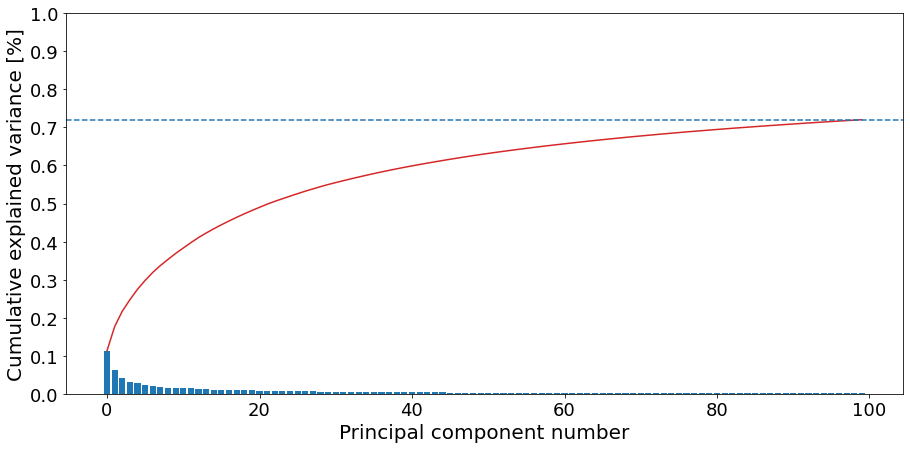

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
ax.plot(pca.explained_variance_ratio_.cumsum(), c='C3')
ax.axhline(y=pca.explained_variance_ratio_.cumsum()[-1], ls='--', c='C0')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0., 1.0)
ax.set_xlabel('Principal component number', fontsize=20)
ax.set_ylabel('Cumulative explained variance [%]', fontsize=20)
ax.tick_params(labelsize=18)

100%|██████████| 39/39 [07:18<00:00, 11.25s/it]
<ipython-input-8-1de079db8d39>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


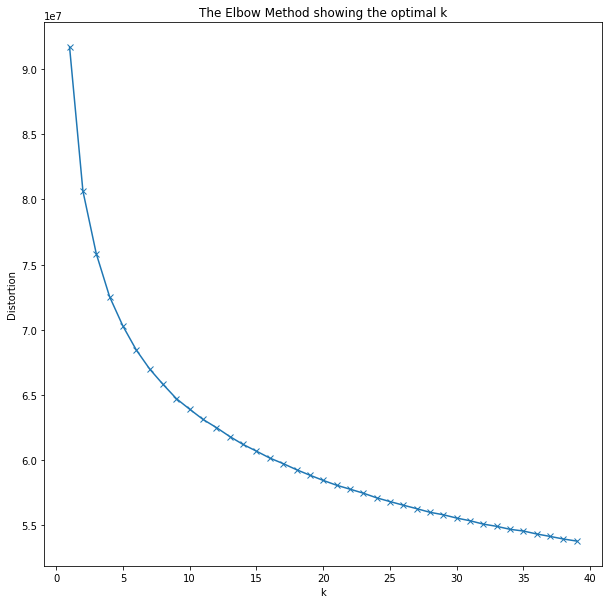

In [8]:
distortions = []
K = range(1, 40)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(x)
    distortions.append(kmeanModel.inertia_)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(K, distortions, 'x-')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
ax.set_title('The Elbow Method showing the optimal k')
fig.show()

In [9]:
n_clusters = 8

# cluster feature vectors
kmeans = KMeans(n_clusters=n_clusters, random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [25]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(groups, cluster, nb_im):
    plt.figure(figsize = (25, 25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > nb_im:
        print(f"Clipping cluster size from {len(files)} to {nb_im}")
        files = files[:nb_im-1]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10, 10, index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [22]:

   
# # this is just incase you want to see which value for k might be the best 
# sse = []
# list_k = list(range(3, 50))

# for k in list_k:
#     km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
#     km.fit(x)
    
#     sse.append(km.inertia_)

# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse)
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance');

In [23]:
for cluster in groups:
    print(cluster, len(groups[cluster]))

5 6103
6 2297
1 6606
7 3343
2 3147
3 5401
0 4186
4 1877


5
Clipping cluster size from 6103 to 10
6
Clipping cluster size from 2297 to 10
1
Clipping cluster size from 6606 to 10
7
Clipping cluster size from 3343 to 10
2
Clipping cluster size from 3147 to 10
3
Clipping cluster size from 5401 to 10
0
Clipping cluster size from 4186 to 10
4
Clipping cluster size from 1877 to 10


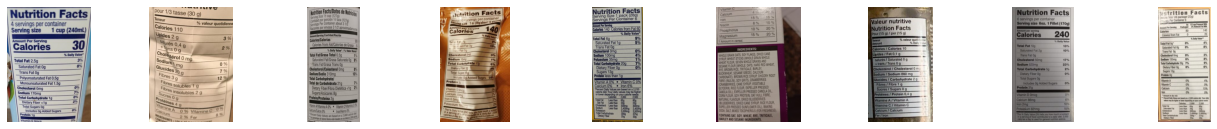

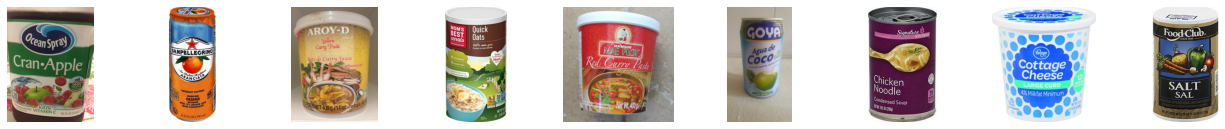

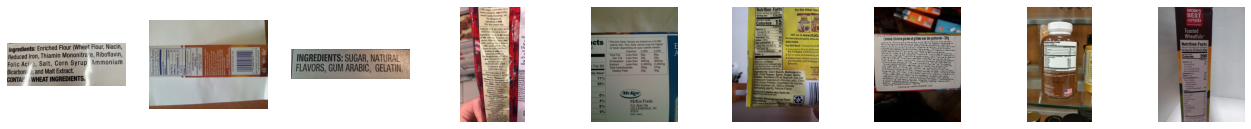

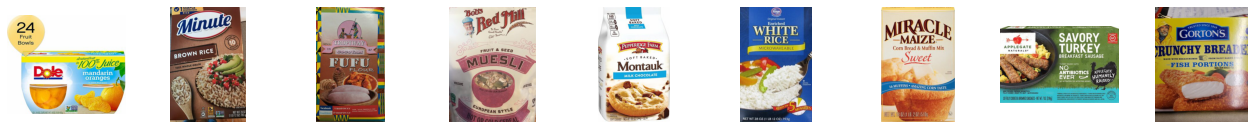

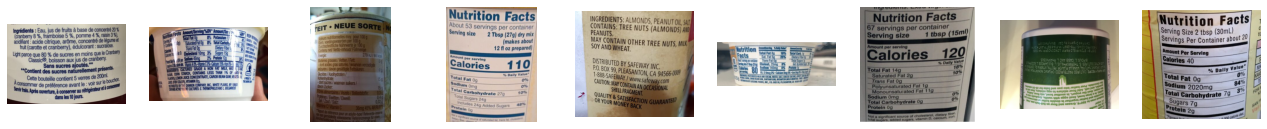

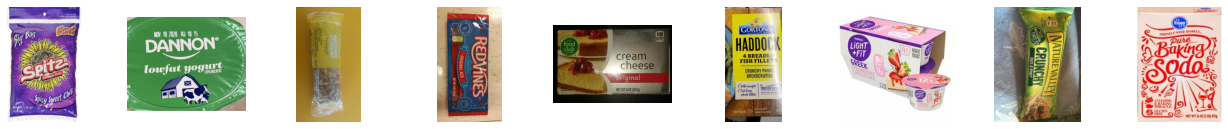

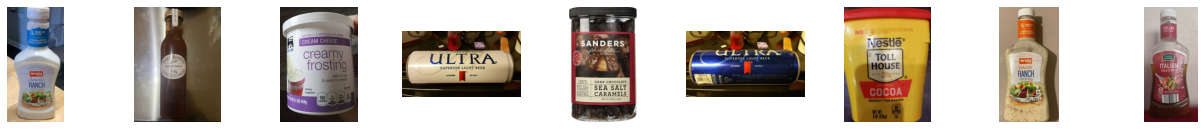

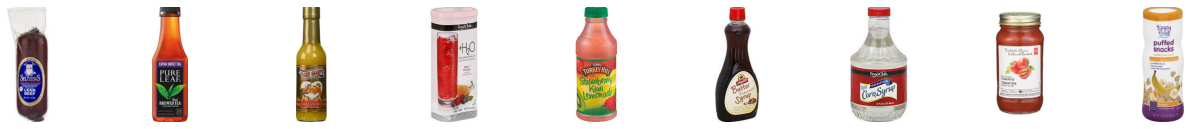

In [24]:
for cluster in groups:
    print(cluster)
    view_cluster(groups, cluster, 10)

In [17]:
# with open('/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/labels_list.txt', 'w') as file:
#     for label in groups[5]+groups[1]+groups[2]:
#         file.write(label+'\n')

## JSON with products names

In [45]:
import json

json_path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/label_of_products.json"

with open(json_path, 'r') as label_file:
    labels = json.load(label_file)

In [46]:
labels['0041570054130']

{'product_name': 'Almond breeze', 'abbreviated_product_name': 'NA'}

In [47]:
len(labels)

100000

In [48]:
for key in labels:
    if key.count('0')==len(key):
        print(key)

0000000000
0000000000000
000
0000


In [18]:
labels

{'0000000000': {'product_name': 'Suppengemüse, 10 Sorten',
  'abbreviated_product_name': 'NA'},
 '0000000000000': {'product_name': 'Chocolat au lait',
  'abbreviated_product_name': 'NA'},
 '0000000031141': {'product_name': 'Moelleux au chocolat',
  'abbreviated_product_name': 'NA'},
 '0000000034791': {'product_name': 'Fromage blanc à la crème de marron',
  'abbreviated_product_name': 'NA'},
 '0000000036252': {'product_name': 'Lion Peanut x2',
  'abbreviated_product_name': 'NA'},
 '0000000038706': {'product_name': 'Moelleux',
  'abbreviated_product_name': 'NA'},
 '0000000039529': {'product_name': 'Pack de 2 Twix',
  'abbreviated_product_name': 'NA'},
 '0000000290616': {'product_name': 'Salade Cesar',
  'abbreviated_product_name': 'NA'},
 '0000000394710': {'product_name': 'Danoises à la cannelle roulées',
  'abbreviated_product_name': 'NA'},
 '0000001071894': {'product_name': 'Flute', 'abbreviated_product_name': 'NA'},
 '0000001938067': {'product_name': 'Chaussons tressés aux pommes',
  

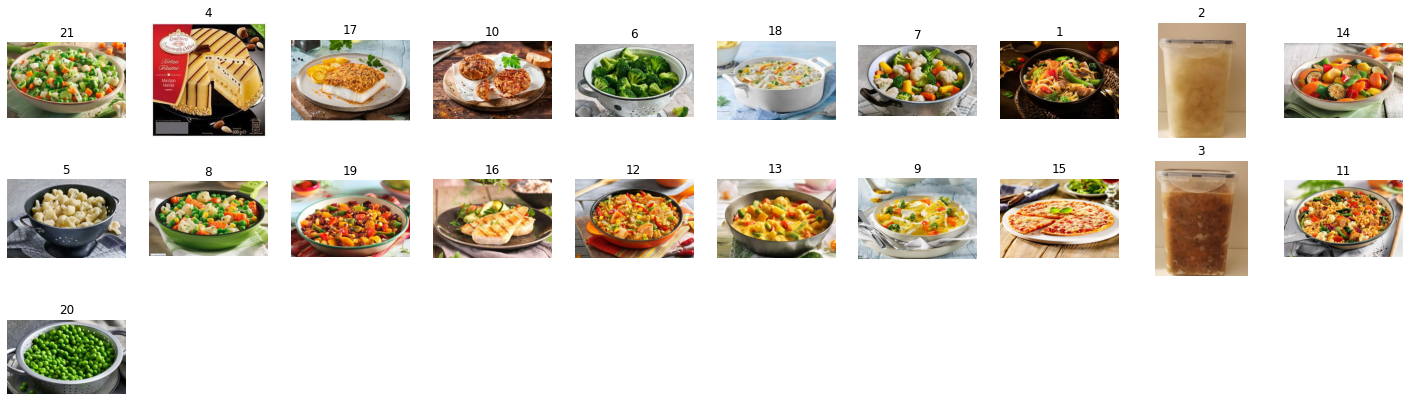

In [49]:
#key = '0041331124669'
key = '0000000000'

index = 0
plt.figure(figsize = (25, 25))
for file in images:
    if file.split('_')[0]==key:
        plt.subplot(10, 10, index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title(file.split('_')[1].split('.')[0])
        index += 1

In [50]:
for g in groups:
    for im in groups[g]:
        if im.split('_')[0]==key:
            print(f"{g}: {im}")

4: 0000000000_18.400.jpg
4: 0000000000_7.400.jpg
4: 0000000000_19.400.jpg
9: 0000000000_2.400.jpg
9: 0000000000_3.400.jpg
9: 0000000000_20.400.jpg
2: 0000000000_21.400.jpg
2: 0000000000_4.400.jpg
2: 0000000000_17.400.jpg
2: 0000000000_10.400.jpg
2: 0000000000_6.400.jpg
2: 0000000000_1.400.jpg
2: 0000000000_14.400.jpg
2: 0000000000_5.400.jpg
2: 0000000000_8.400.jpg
2: 0000000000_16.400.jpg
2: 0000000000_12.400.jpg
2: 0000000000_13.400.jpg
2: 0000000000_9.400.jpg
2: 0000000000_15.400.jpg
2: 0000000000_11.400.jpg


## Different clustering with DBSCAN

In [142]:
neigh = NearestNeighbors(n_neighbors=10, n_jobs=-1)
nbrs = neigh.fit(x)
distances, indices = nbrs.kneighbors(x)

In [143]:
distances.shape, indices.shape

((32960, 10), (32960, 10))

In [144]:
indices

array([[    0,  5349, 15471, ..., 18073, 12728,  9372],
       [    1, 31936, 12742, ...,  1480, 17718, 17708],
       [    2, 27455, 28894, ..., 29390,  8929,   425],
       ...,
       [32957, 18697,  5595, ...,  3314,  3651, 29282],
       [32958,  7134,  7590, ..., 17053, 19035, 31439],
       [32959, 30851, 10318, ...,    77, 17871, 29705]])

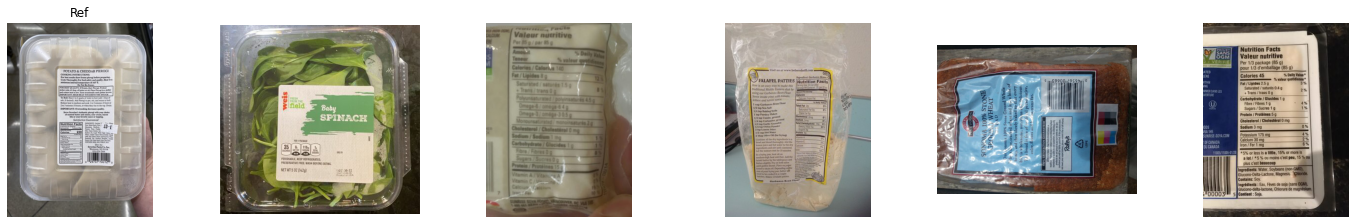

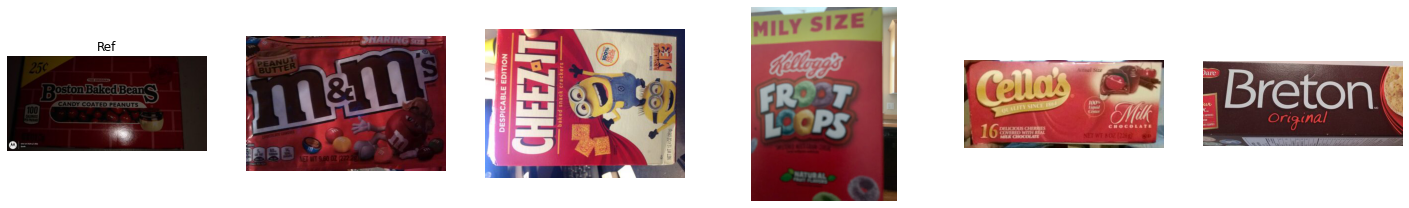

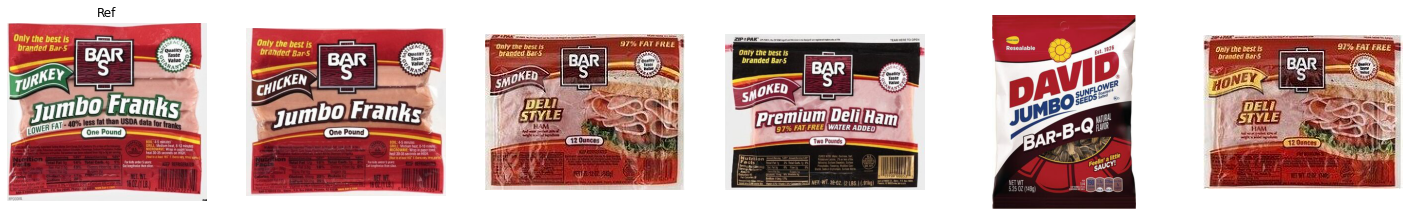

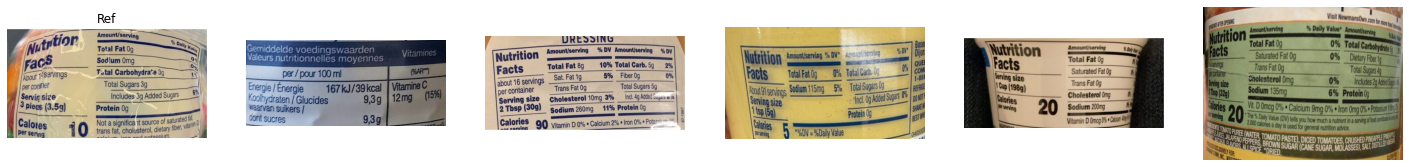

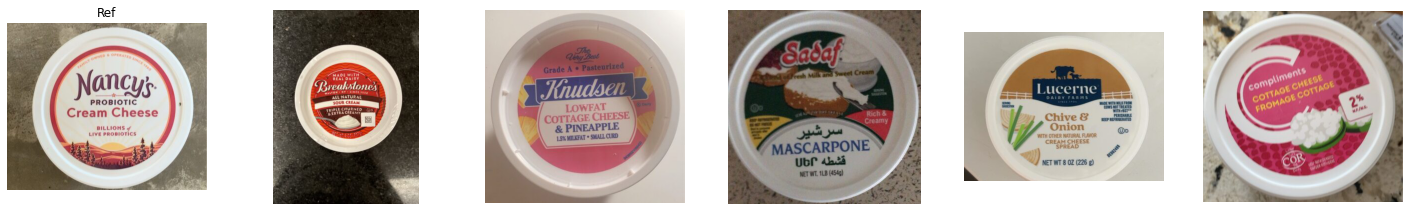

In [175]:
#key = '0041331124669'
nb_neighbours = 5

for key in np.random.choice(range(len(images)), size=5, replace=False):
    index = 0
    fig = plt.figure(figsize=(25, 25))
    im_neighbours = [images[key]] + [images[i] for i in indices[key][1:nb_neighbours+1]]
    for im in im_neighbours:
        plt.subplot(6, 6, index+1)
        img = load_img(im)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        if index==0:
            plt.title('Ref')
        index += 1

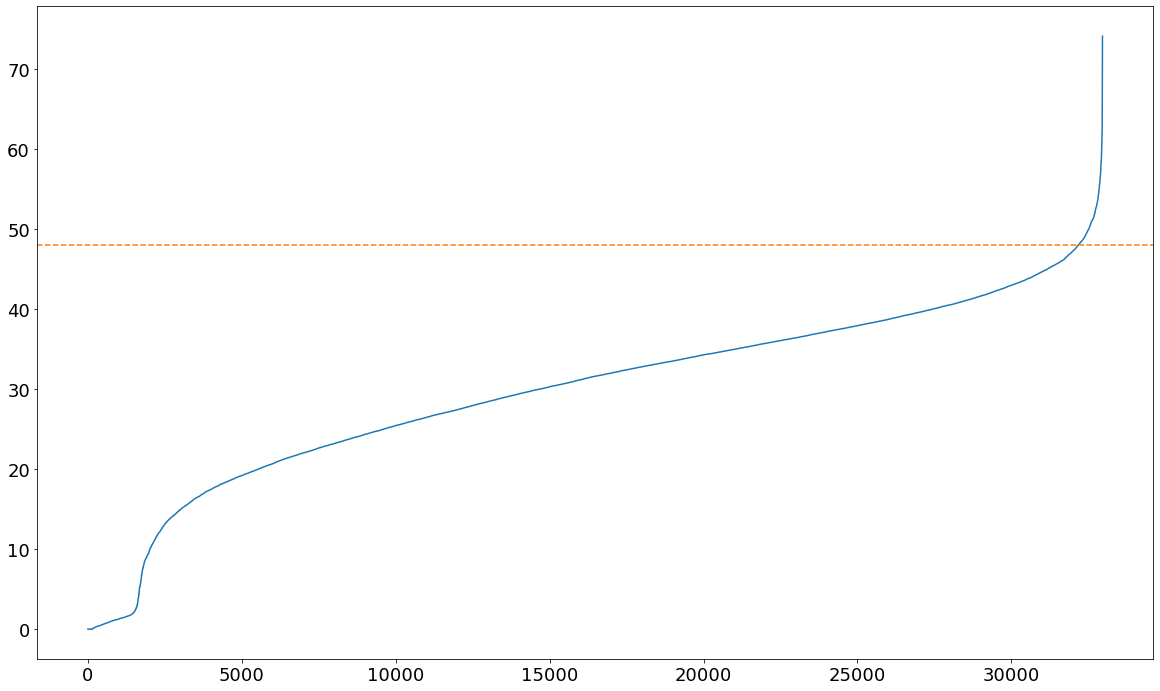

In [77]:
distances_sorted = np.sort(distances, axis=0)
distances_sorted = distances_sorted[:,1]
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(distances_sorted)
ax.axhline(y=48, ls='--', c='C1')
ax.tick_params(labelsize=18)
# ax.set_xlim(0, 2500)
# ax.set_ylim(0, 5)

In [117]:
dbscan = DBSCAN(eps=48, min_samples=100)
dbscan.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames, dbscan.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [116]:
for cluster in groups:
    print(cluster, len(groups[cluster]))

0 32960


Clipping cluster size from 31754 to 30
Clipping cluster size from 1206 to 30


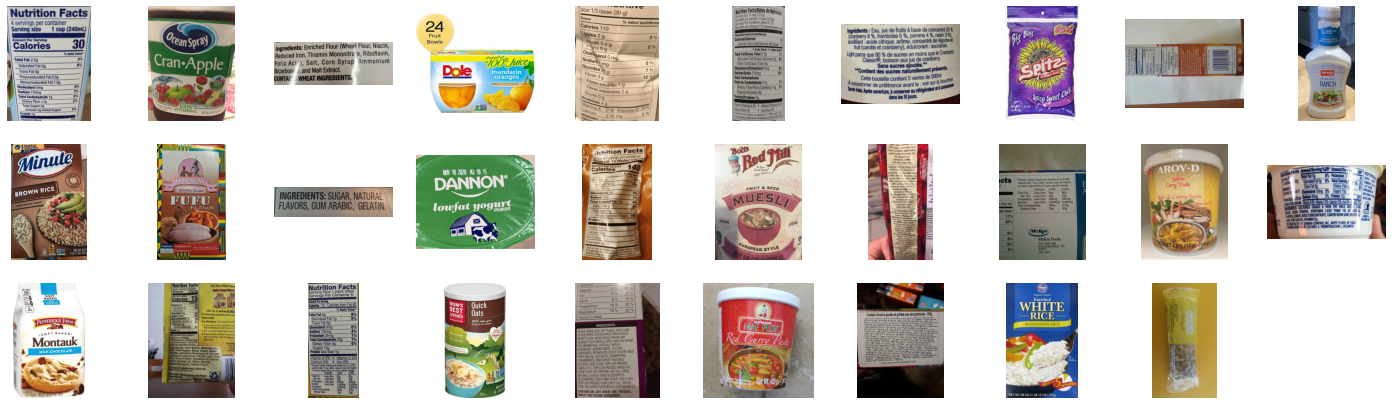

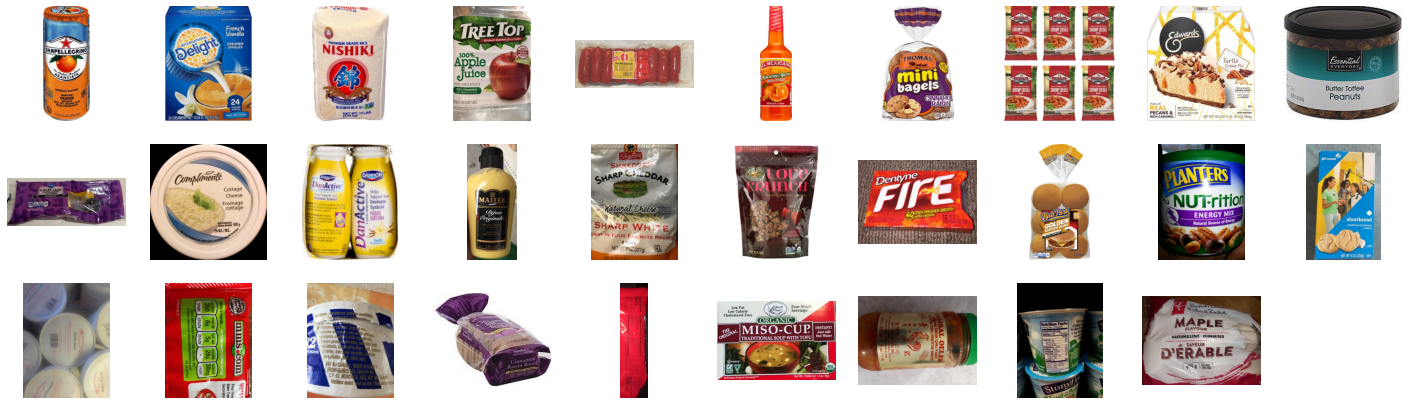

In [80]:
for cluster in groups:
    view_cluster(cluster)

Text(0, 0.5, 'PC2')

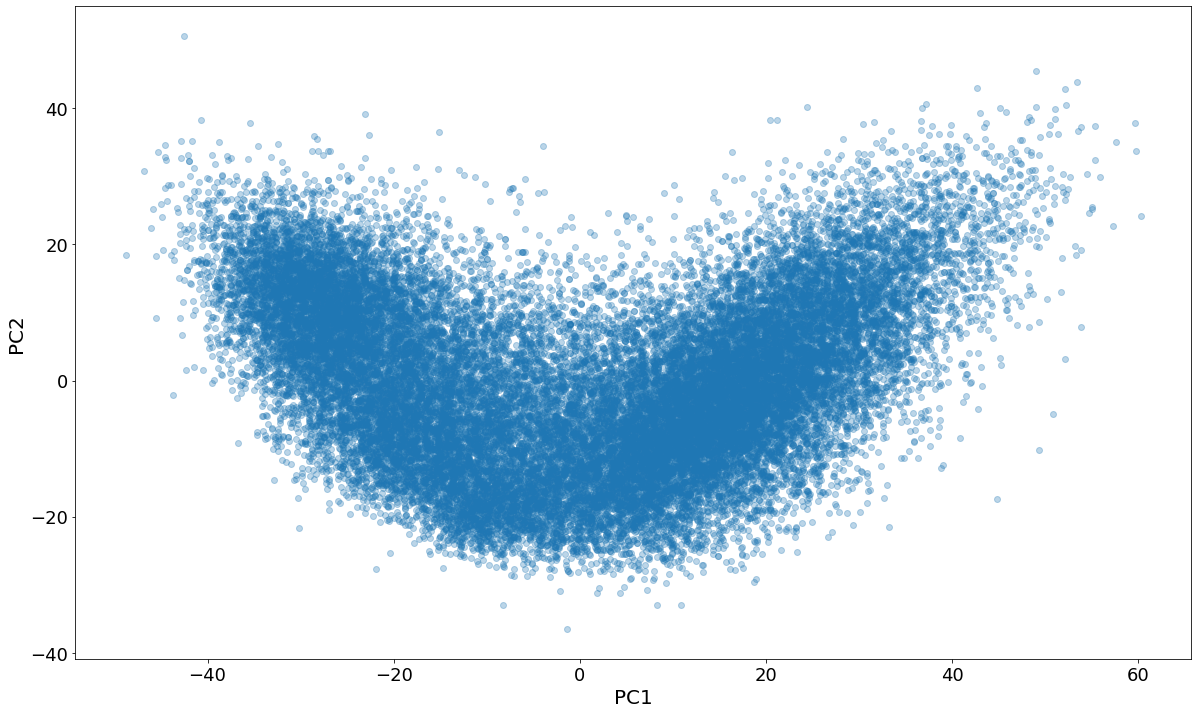

In [111]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(x[:, 0], x[:, 2], alpha=0.3)
ax.tick_params(labelsize=18)
ax.set_xlabel('PC1', fontsize=20)
ax.set_ylabel('PC2', fontsize=20)
